In this notebook, useful data loading and transforming functions are demonstrated.  The main sources of data are Quandl, Cryptocompare and Yahoo Finance.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [80]:
import os
import re
import pickle
import itertools
from tqdm import tqdm, tqdm_notebook
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [12, 4]

import quandl

In [88]:
from utils import *

# Quandl

In [4]:
api_key = open(file='quandl_api').read().replace('\n', '')
quandl.ApiConfig.api_key = api_key

## Exchange Data International

One may use [_Exchange Data International_](https://www.quandl.com/publishers/edi) free sample series as follows:

In [ ]:
print(os.listdir(QUANDL_PATH + 'EDI/'))

In [ ]:
# tickers, prices = get_quandl_edi(get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys())), download=True)  # The first time...
tickers, prices = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()))

In [ ]:
prices

In [ ]:
print('Number of price series:', len(tickers))

In [ ]:
j = np.random.choice(len(tickers) - 1)
ticker_j = list(tickers)[j]
print('j:', j, ' - ', ticker_j)
price_j = prices.loc[ticker_j]
price_j[['Open', 'High', 'Low', 'Close']].plot();

In [ ]:
price_j

##  Sharadar Equity Prices

One may use [_Sharadar Equity Prices_](https://www.quandl.com/publishers/sharadar) free sample series as follows:

In [ ]:
# tickers, prices = get_quandl_sharadar(download=True)  # The first time...
tickers, prices = get_quandl_sharadar(free=False)

In [ ]:
print('Number of price series:', len(tickers))

In [ ]:
prices

In [ ]:
j = np.random.choice(len(tickers) - 1)
ticker_j = list(tickers)[j]
print('j:', j, ' - ', ticker_j)
price_j = prices.loc[ticker_j]
price_j[['Open', 'High', 'Low', 'Close']].plot()
plt.axhline(c='grey')
plt.show()

In [ ]:
price_j

### Metadata...

In [ ]:
shr_meta = pd.read_csv(QUANDL_PATH + 'Sharadar/SHARADAR-TICKERS.csv')
shr_meta.to_excel(QUANDL_PATH + 'Sharadar/SHARADAR-TICKERS.xlsx')
shr_meta.keys()

In [ ]:
shr_meta.describe(include=np.object)

In [ ]:
shr_meta.groupby('currency').count()

### Train, Dev, Test samples 

In [11]:
p_train = 0.7
p_dev = 0.15

In [10]:
N = len(tickers)
train, dev = round(p_train * N), round(p_dev * N)
test = N - train - dev
print('N:', N, ', Tain:', train, ', Dev:', dev, ', Test:', test)

NameError: name 'tickers' is not defined

In [ ]:
np.random.seed(123)
tickers_full = list(np.random.permutation(tickers))
tickers_train = tickers_full[:train]
tickers_dev = tickers_full[train:(train + dev)]
tickers_test = tickers_full[-test:]
assert len(tickers_train + tickers_dev + tickers_test) == N

In [ ]:
tickers_in_train_folder = [f.replace('.feather', '') for f in os.listdir(QUANDL_PATH + 'Sharadar/train/')]
set(tickers_train) == set(tickers_in_train_folder)

In [ ]:
# # Only run once
# for t in tickers_train:
#     prices.loc[t].reset_index().to_feather(fname=QUANDL_PATH + 'Sharadar/train/' + t + '.feather')

In [ ]:
# # Only run once
# for t in tickers_dev:
#     prices.loc[t].reset_index().to_feather(fname=QUANDL_PATH + 'Sharadar/dev/' + t + '.feather')

In [ ]:
# # Only run once
# for t in tickers_test:
#     prices.loc[t].reset_index().to_feather(fname=QUANDL_PATH + 'Sharadar/test/' + t + '.feather')

In [ ]:
dir_train = os.listdir(QUANDL_PATH + 'Sharadar/train/')
tickers_train = [f.replace('.feather', '') for f in dir_train]
train_files = [QUANDL_PATH + 'Sharadar/train/' + f for f in dir_train]
prices_train = pd.read_feather(train_files[0]).assign(Ticker=tickers_train[0])

for i in tqdm_notebook(range(1, len(tickers_train))):
    df_i = pd.read_feather(train_files[i]).assign(Ticker=tickers_train[i])
    prices_train = pd.concat((prices_train, df_i), axis=0)

In [54]:
def select_train_dev_test(x, ptr=0.7, pdv=0.15, pts=0.15):
    y = ['train'] * int(len(x) * ptr) + ['dev'] * int(len(x) * pdv)
    y += ['test'] * (len(x) - len(y))
    return(y)

prices_train = prices_train.sort_values(['Ticker', 'Date'])
prices_train = prices_train.assign(Set=np.nan)
prices_train['Set'] = prices_train.groupby(prices_train['Ticker'], sort=False).transform(select_train_dev_test)
prices_train.reset_index().drop('index', axis=1).to_feather(fname=QUANDL_PATH + 'Sharadar/sharadar_train.feather')

In [ ]:
dir_dev = os.listdir(QUANDL_PATH + 'Sharadar/dev/')
tickers_dev = [f.replace('.feather', '') for f in dir_dev]
dev_files = [QUANDL_PATH + 'Sharadar/dev/' + f for f in dir_dev]
prices_dev = pd.read_feather(dev_files[0]).assign(Ticker=tickers_dev[0])

for i in tqdm_notebook(range(1, len(tickers_dev))):
    df_i = pd.read_feather(dev_files[i]).assign(Ticker=tickers_dev[i])
    prices_dev = pd.concat((prices_dev, df_i), axis=0)

prices_dev.reset_index().drop('index', axis=1).to_feather(fname=QUANDL_PATH + 'Sharadar/sharadar_dev.feather')

In [81]:
dir_test = os.listdir(QUANDL_PATH + 'Sharadar/test/')
tickers_test = [f.replace('.feather', '') for f in dir_test]
test_files = [QUANDL_PATH + 'Sharadar/test/' + f for f in dir_test]
prices_test = pd.read_feather(test_files[0]).assign(Ticker=tickers_test[0])

for i in tqdm_notebook(range(1, len(tickers_test))):
    df_i = pd.read_feather(test_files[i]).assign(Ticker=tickers_test[i])
    prices_test = pd.concat((prices_test, df_i), axis=0)

prices_test.reset_index().drop('index', axis=1).to_feather(fname=QUANDL_PATH + 'Sharadar/sharadar_test.feather')



Exception ignored in: <bound method tqdm.__del__ of  10%|███████▉                                                                     | 198/1930 [09:47<1:25:37,  2.97s/it]>
Traceback (most recent call last):
  File "C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\tqdm\_tqdm.py", line 882, in __del__
    self.close()
  File "C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\tqdm\_tqdm.py", line 1087, in close
    self._decr_instances(self)
  File "C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\tqdm\_tqdm.py", line 452, in _decr_instances
    cls.monitor.exit()
  File "C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\tqdm\_monitor.py", line 50, in exit
    self.join()
  File "C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


### Train, dev, test split within train 

In [101]:
 t_train, p_train = get_sharadar_train()

In [102]:
ticker = np.random.choice(t_train)
price = p_train.loc[ticker]

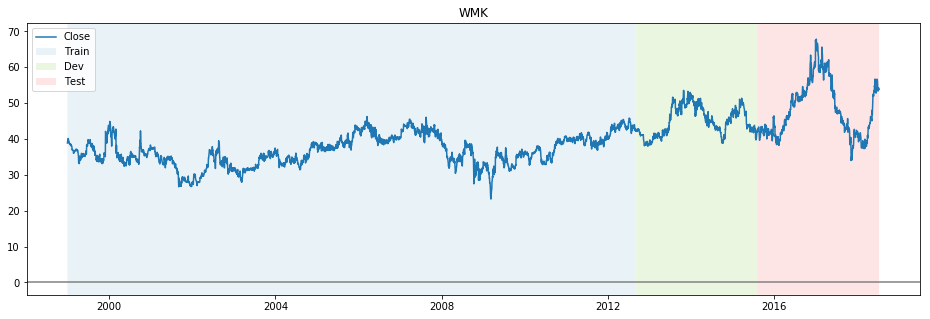

In [103]:
pal = plt.get_cmap('Paired').colors
fig, ax = plt.subplots(figsize=(16, 5))
trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(price.index, 0, price.High.max(), where=(price.Set == 'train'), facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Train')
ax.fill_between(price.index, 0, price.High.max(), where=(price.Set == 'dev'), facecolor=pal[2],
                        alpha=0.25, transform=trans, label='Dev')
ax.fill_between(price.index, 0, price.High.max(), where=(price.Set == 'test'), facecolor=pal[4],
                        alpha=0.25, transform=trans, label='Test')
plt.plot(price.Close, label='Close')
plt.axhline(0, c='grey')
plt.legend()
plt.title(ticker)
plt.show()

## Cryptocompare
TO DO

## Yahoo Finance
TO DO

# Data Cleaning

* OHLC: open and close within [low, high].

## Data Transforms

* Weekly and monthly OHLC prices.
* Zero volume days.
* Returns.
* Technical Indicators (volatility, skewness, etc.)

In [ ]:
weekly_j = daily_to_weekly_prices(price_j)

In [ ]:
weekly_j[['Open', 'High', 'Low', 'Close']].plot();